In [32]:
from __future__ import print_function

In [2]:
import six

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import six

sns.set(style='ticks', context='paper', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})

%matplotlib inline


folder = 'figures'
!mkdir $folder
import flotilla
flotilla_dir = '/projects/ps-yeolab/obotvinnik/flotilla_projects'

study = flotilla.embark('singlecell_pnm_figure2_modalities_bayesian', flotilla_dir=flotilla_dir)
not_outliers = study.splicing.singles.index.difference(study.splicing.outliers.index)

psi = study.splicing.singles.ix[not_outliers]
grouped = psi.groupby(study.sample_id_to_phenotype)
psi_filtered = grouped.apply(lambda x: x.dropna(axis=1, thresh=20))

mkdir: cannot create directory `figures': File exists


/home/obotvinnik/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:810: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/obotvinnik/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())
/home/obotvinnik/anaconda/lib/python2.7/site-packages/flotilla/__init__.py:65: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  load_species_data=load_species_data)


2016-06-13 06:54:51	Reading datapackage from /projects/ps-yeolab/obotvinnik/flotilla_projects/singlecell_pnm_figure2_modalities_bayesian/datapackage.json
2016-06-13 06:54:51	Parsing datapackage to create a Study object
2016-06-13 06:59:38 	Initializing Study
2016-06-13 06:59:38 	Initializing Predictor configuration manager for Study
2016-06-13 06:59:38	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-06-13 06:59:38	Added ExtraTreesClassifier to default predictors
2016-06-13 06:59:38	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-06-13 06:59:38	Added ExtraTreesRegressor to default predictors
2016-06-13 06:59:38	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-06-13 06:59:38	Added GradientBoostingClassifier to default predictors
2016-06-13 06:59:38	Predictor GradientBoostingRegressor is of type <class 'sklear

In [3]:
figure_folder = '{}/intron_conservation'.format(folder)
! mkdir $figure_folder

mkdir: cannot create directory `figures/intron_conservation': File exists


In [4]:
ls /projects/ps-yeolab/obotvinnik/singlecell_pnms/exon2*csv

ls: cannot access /projects/ps-yeolab/obotvinnik/singlecell_pnms/exon2*csv: No such file or directory


In [5]:
csv_folder = '/projects/ps-yeolab/obotvinnik/singlecell_pnms/csvs_for_paper'

In [6]:
splicing_feature_folder = '{}/splicing_feature_data'.format(csv_folder)
alternative_feature_folder = '{}/alternative'.format(splicing_feature_folder)
constitutive_feature_folder = '{}/constitutive'.format(splicing_feature_folder)

In [7]:
alternative_feature_folder

'/projects/ps-yeolab/obotvinnik/singlecell_pnms/csvs_for_paper/splicing_feature_data/alternative'

In [8]:
downstream = pd.read_csv('{}/downstream400_placental_mammal_conservation.csv'.format(alternative_feature_folder), 
                         index_col=0)
upstream = pd.read_csv('{}/upstream400_placental_mammal_conservation.csv'.format(alternative_feature_folder), 
                       index_col=0)

In [9]:
conservation_folder = '{}/conservation'.format(folder)

In [10]:
from anchor import MODALITY_ORDER, MODALITY_PALETTE

In [11]:
sns.set(style='ticks', context='paper')

In [12]:
from anchor import MODALITY_ORDER

In [13]:
constitutive_downstream = pd.read_csv('{}/downstream400_placental_mammal_conservation.csv'.format(constitutive_feature_folder), 
                         index_col=0)
constitutive_upstream = pd.read_csv('{}/upstream400_placental_mammal_conservation.csv'.format(constitutive_feature_folder), 
                       index_col=0)

In [14]:
constitutive_conservations = {'Upstream': constitutive_upstream, 'Downstream': constitutive_downstream}

In [15]:
from scipy.stats import mannwhitneyu

In [16]:
# %%time

intron_conservations = {'Upstream': upstream, 
                        'Downstream': downstream}

modality_basewise_conservation_dfs = []

intron_order = ['Upstream', 'Downstream']

values_col = r'$\mathrm{sgn}(\Delta\mathrm{mean}) \times\left(-\log_{10}(q)\right)$'


phenotype_basewise_statistics_dfs = []

for phenotype, phenotype_df in study.supplemental.modalities_tidy.groupby('phenotype'):
    modalities = phenotype_df.set_index('event_id').modality
    modalities = modalities.drop(modalities.index.get_duplicates())
    
    conservation_dfs = []
    basewise_statistics_dfs = []
    

    for intron_name, intron_conservation in intron_conservations.items():
        mean_conservation = intron_conservation.groupby(modalities).mean()
        mean_conservation.columns = mean_conservation.columns.astype(int) + 1
        tidy = mean_conservation.unstack().reset_index()
        tidy = tidy.rename(columns={'level_0':'genome_direction_nt', 0: 'Conservation'})
        tidy['direction'] = intron_name
        conservation_dfs.append(tidy)
        conservation_grouped = intron_conservation.groupby(modalities)
#         constitutive_name = '~1'

#         constitutive = conservation_grouped.get_group(constitutive_name)
        constitutive = constitutive_conservations[intron_name]
    
        constitutive_mean = constitutive.mean()
        constitutive_mean.index = constitutive_mean.index.astype(int) + 1
        tidy = constitutive_mean.reset_index()
        tidy['modality'] = 'constitutive'
        tidy['direction'] = intron_name
        tidy = tidy.rename(columns={'index':'genome_direction_nt', 0: 'Conservation'})
        conservation_dfs.append(tidy)
        
        for modality, df in conservation_grouped:
#             if modality == constitutive_name:
#                 continue
            lines = []

            for i in df:
                statistic, p_value = mannwhitneyu(df[i], constitutive[i])
                sign = np.sign(df[i].mean() - constitutive[i].mean())
                lines.append([statistic, p_value, sign])
            intron_basewise_statistics = pd.DataFrame(lines, columns=['U Statistic', '$p$-value', 'sign'])
            intron_basewise_statistics['$q$-value'] = intron_basewise_statistics.shape[0] * intron_basewise_statistics['$p$-value']
            intron_basewise_statistics['modality'] = modality
            intron_basewise_statistics['intron'] = intron_name
            intron_basewise_statistics = intron_basewise_statistics.reset_index()
            intron_basewise_statistics = intron_basewise_statistics.rename(columns={'index': 'genome_direction_nt'})
#             print '\n', phenotype, intron_name, modality
#             print intron_basewise_statistics.groupby('genome_direction_nt').size().head()
            basewise_statistics_dfs.append(intron_basewise_statistics)

    basewise_statistics = pd.concat(basewise_statistics_dfs, ignore_index=True)
    basewise_statistics['$-\log_{10}(q)$'] = -np.log10(basewise_statistics['$q$-value'])
    basewise_statistics['$-\log_{10}(p)$'] = -np.log10(basewise_statistics['$p$-value'])

    basewise_statistics[values_col] = basewise_statistics['sign'] * basewise_statistics['$-\log_{10}(q)$']
    basewise_statistics['phenotype'] = phenotype
#     print basewise_statistics.groupby(['modality', 'intron', 'genome_direction_nt']).size().head()
#     print 'basewise_statistics.shape', basewise_statistics.shape
    phenotype_basewise_statistics_dfs.append(basewise_statistics)
#     basewise_statistics.head()

#         var_conservation = intron_conservation.groupby(modalities).var()
    modality_basewise_conservation = pd.concat(conservation_dfs, ignore_index=True)
    modality_basewise_conservation['phenotype'] = phenotype
    modality_basewise_conservation_dfs.append(modality_basewise_conservation)

modality_basewise_conservation = pd.concat(modality_basewise_conservation_dfs, ignore_index=True)
six.print_(modality_basewise_conservation.shape)
modality_basewise_statistics = pd.concat(phenotype_basewise_statistics_dfs, ignore_index=True)
six.print_(modality_basewise_statistics.shape)
modality_basewise_statistics.head()

(12800, 5)
(10400, 11)


,genome_direction_nt,U Statistic,$p$-value,sign,$q$-value,modality,intron,$-\log_{10}(q)$,$-\log_{10}(p)$,$\mathrm{sgn}(\Delta\mathrm{mean}) \times\left(-\log_{10}(q)\right)$,phenotype
0,0,3494411.0,1.786188e-08,-1,0.000007,bimodal,Downstream,5.146013,7.748073,-5.146013,MN
1,1,3593197.5,2.864930e-05,-1,0.011460,bimodal,Downstream,1.940826,4.542886,-1.940826,MN
2,2,3756166.0,7.380786e-02,-1,29.523142,bimodal,Downstream,-1.470163,1.131897,1.470163,MN
3,3,3881496.0,9.542460e-01,-1,381.698401,bimodal,Downstream,-2.581720,0.020340,2.581720,MN
4,4,3975242.5,1.524522e-01,-1,60.980880,bimodal,Downstream,-1.785194,0.816866,1.785194,MN


In [ ]:
for intron_name, intron_conservation in intron_conservations.items():
    if intron_name == 'Upstream':
        subset = intron_conservation[np.arange(350, 400)]
    else:
        subset = intron_conservation[np.arange(50)]
    mean_conservation = intron_conservation.groupby(modalities).mean()
    mean_conservation.columns = mean_conservation.columns.astype(int) + 1
    tidy = mean_conservation.unstack().reset_index()
    tidy = tidy.rename(columns={'level_0':'genome_direction_nt', 0: 'Conservation'})
    tidy['direction'] = intron_name
    conservation_dfs.append(tidy)
    conservation_grouped = intron_conservation.groupby(modalities)
#         constitutive_name = '~1'

#         constitutive = conservation_grouped.get_group(constitutive_name)
    constitutive = constitutive_conservations[intron_name]

    constitutive_mean = constitutive.mean()
    constitutive_mean.index = constitutive_mean.index.astype(int) + 1
    tidy = constitutive_mean.reset_index()
    tidy['modality'] = 'constitutive'
    tidy['direction'] = intron_name
    tidy = tidy.rename(columns={'index':'genome_direction_nt', 0: 'Conservation'})
    conservation_dfs.append(tidy)

In [22]:
intron_name

'Upstream'

In [23]:
subset = intron_conservation[np.arange(350, 400)]
subset.head()

,350,351,352,353,354,355,356,357,358,359,...,390,391,392,393,394,395,396,397,398,399
exon:chr2:122204913-122205083:-@exon:chr2:122203025-122203072:-@exon:chr2:122187649-122187753:-,0.000,0.000,0.006,0.003,0.003,0.000,0.000,0.000,0.000,0.002,...,0.993,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
exon:chr1:222997226-222997287:+@exon:chr1:223073123-223073207:+@exon:chr1:223116149-223116674:+,0.016,0.017,0.019,0.019,0.019,0.018,0.017,0.015,0.012,0.013,...,0.002,0.001,0.001,0.001,0.001,0.001,0.002,0.001,0.002,0.001
exon:chr19:5690327-5690611:+@exon:chr19:5691330-5691464:+@exon:chr19:5691543-5691678:+,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.002,0.002,...,0.039,0.209,0.277,0.376,0.399,0.479,0.490,0.620,0.907,0.983
exon:chr6:111195988-111196418:+@exon:chr6:111208708-111208794:+@exon:chr6:111210060-111210186:+,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
exon:chr2:55544700-55544977:-@exon:chr2:55544342-55544485:-@exon:chr2:55543064-55543250:-,0.045,0.013,0.022,0.382,0.373,0.012,0.001,0.000,0.000,0.003,...,0.146,0.001,0.000,0.000,0.002,0.013,0.102,0.989,0.998,0.998


In [25]:
phenotype

'iPSC'

## Look at overall distribution of conservation at basewise level

In [31]:
subset_tidy = subset.unstack().reset_index()
subset_tidy = subset_tidy.rename(columns={'level_0': 'genome_direction_nt',
                                          'level_1': 'event_id', 0:'Conservation'})
subset_tidy.head()

,genome_direction_nt,event_id,Conservation
0,350,exon:chr2:122204913-122205083:-@exon:chr2:1222...,0.000
1,350,exon:chr1:222997226-222997287:+@exon:chr1:2230...,0.016
2,350,exon:chr19:5690327-5690611:+@exon:chr19:569133...,0.000
3,350,exon:chr6:111195988-111196418:+@exon:chr6:1112...,0.000
4,350,exon:chr2:55544700-55544977:-@exon:chr2:555443...,0.045


In [33]:
subset_modalities = subset_tidy.join(modalities, on='event_id')
print(subset_modalities.shape)
subset_modalities.head()

(2195150, 4)


,genome_direction_nt,event_id,Conservation,modality
0,350,exon:chr2:122204913-122205083:-@exon:chr2:1222...,0.000,NaN
1,350,exon:chr1:222997226-222997287:+@exon:chr1:2230...,0.016,NaN
2,350,exon:chr19:5690327-5690611:+@exon:chr19:569133...,0.000,included
3,350,exon:chr6:111195988-111196418:+@exon:chr6:1112...,0.000,included
4,350,exon:chr2:55544700-55544977:-@exon:chr2:555443...,0.045,bimodal


In [17]:
# subset = modality_basewise_conservation.query('(genome_direction_nt > 350 & direction == "Upstream") | (genome_direction_nt < 50 & direction == "Downstream")')
# subset.shape

# subset.head()

(1584, 5)

In [19]:
sns.set(context='paper', style='white')

In [43]:
sns.stripplot

In [ ]:
modality_order = ['excluded', 'bimodal']

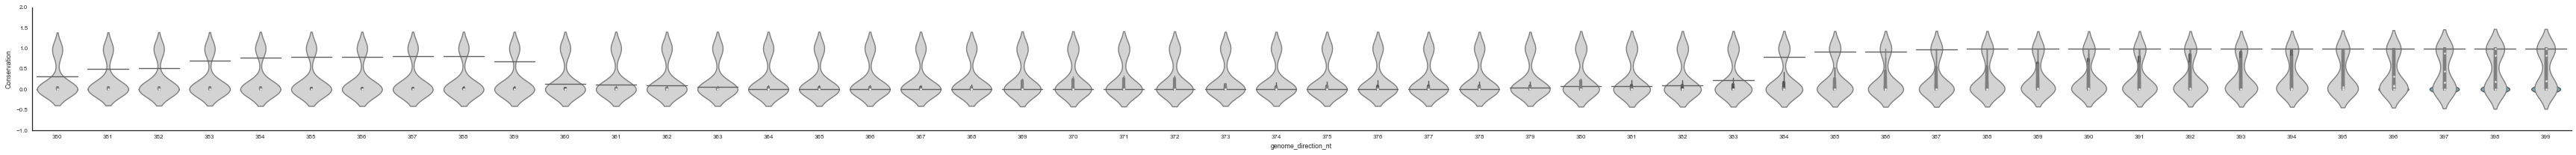

In [46]:
g = sns.FacetGrid(subset_modalities, hue='modality', hue_order=MODALITY_ORDER, 
                  palette=MODALITY_PALETTE, aspect=16)
# g.map(sns.pointplot, 'genome_direction_nt', 'Conservation')
# g.map(sns.stripplot, 'genome_direction_nt', 'Conservation', jitter=True, split=True)
g.map(sns.violinplot, 'genome_direction_nt', 'Conservation')
# g.map(sns.pointplot, 'genome_direction_nt', 'Conservation', dodge=True)

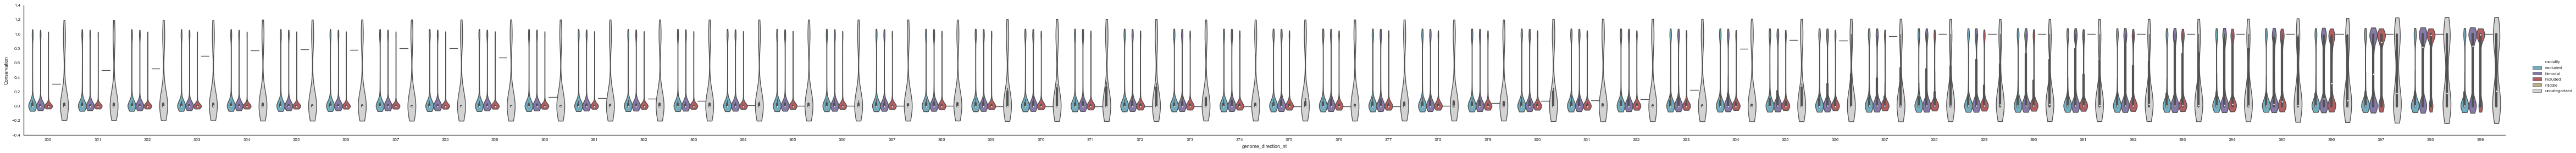

In [51]:
g = sns.factorplot('genome_direction_nt', 'Conservation', data=subset_modalities, hue='modality', hue_order=MODALITY_ORDER, 
                  palette=MODALITY_PALETTE, aspect=16, kind='violin', cut=True, scale='width')
# g.map(sns.stripplot, 'genome_direction_nt', 'Conservation', jitter=True, split=True)

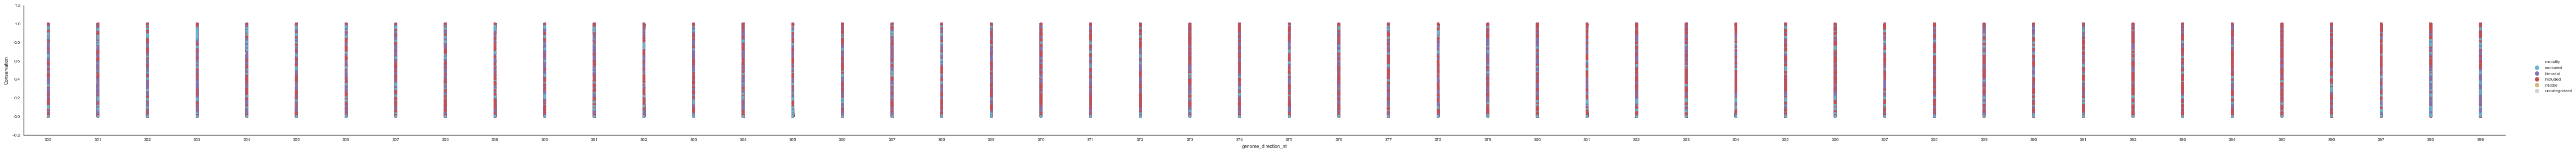

In [49]:
g = sns.factorplot('genome_direction_nt', 'Conservation', data=subset_modalities, hue='modality', hue_order=MODALITY_ORDER, 
                  palette=MODALITY_PALETTE, aspect=16, kind='strip', jitter=True, split=True)

In [ ]:
g = sns.factorplot('genome_direction_nt', 'Conservation', data=subset_modalities, hue='modality', hue_order=MODALITY_ORDER, 
                  palette=MODALITY_PALETTE, aspect=16, kind='violin')

In [43]:
# g = sns.FacetGrid(subset_modalities, hue='modality', hue_order=MODALITY_ORDER, 
#                   palette=MODALITY_PALETTE, aspect=16)
# # g.map(sns.pointplot, 'genome_direction_nt', 'Conservation')
# g.map(sns.swarmplot, 'genome_direction_nt', 'Conservation')
# # g.map(sns.pointplot, 'genome_direction_nt', 'Conservation', dodge=True)

KeyboardInterrupt: 

KeyboardInterrupt: 

### Statistical enrichment of modality conservation within modality, across celltypes

Answering the question,

> How does intron conservation of bimodal introns change across different cell type?

In [33]:
modality_basewise_conservation.head()

,Conservation,direction,genome_direction_nt,modality,phenotype
0,0.602612,Downstream,1,bimodal,MN
1,0.206020,Downstream,1,excluded,MN
2,0.721382,Downstream,1,included,MN
3,1.000000,Downstream,1,uncategorized,MN
4,0.606266,Downstream,2,bimodal,MN


In [48]:
import itertools

lines = []
col = 'Conservation'

for (modality, context), df in modality_basewise_conservation.groupby(['modality', 'direction']):
    grouped = df.groupby('phenotype')
    
    for (group1, df1), (group2, df2) in itertools.product(grouped, repeat=2):
        result = mannwhitneyu(df1[col], df2[col])
        lines.append([modality, context, group1, group2, result.pvalue, result.statistic])
enrichment = pd.DataFrame(lines, columns=['modality', 'context', 'phenotype1', 'phenotype2', 'p_value', 'statistic'])


# multiple testing correction
enrichment['bonferonni_p_value'] = enrichment['p_value'] * enrichment.shape[0]
enrichment.head()

# Transform tidy dataframe into 2d matrix
enrichment_2d = enrichment.groupby('modality').apply(
    lambda x: x.pivot_table(index='phenotype1', columns=['context', 'phenotype2'], values='bonferonni_p_value'))
# enrichment_2d = enrichment_2d.loc[modality_order]
enrichment_2d_log10 = -np.log10(enrichment_2d)

# Make the rows and columns in the order we want
index = pd.MultiIndex.from_product([MODALITY_ORDER, study.phenotype_order])
columns = pd.MultiIndex.from_product([intron_order, study.phenotype_order])
enrichment_2d_log10 = enrichment_2d_log10.reindex(index=index, columns=columns)
enrichment_2d_log10

# # Plot p-value heatmap
# fig, ax = plt.subplots(figsize=(.5, .75))
# ipsc = enrichment_2d_log10.loc['iPSC']
# ipsc = ipsc.loc[modality_order]
# ipsc = ipsc.T.fillna(0) + ipsc.fillna(0)
# ipsc = ipsc.replace(0, np.nan)
# six.print_(ipsc)

# sns.heatmap(ipsc, vmin=0, vmax=100, linewidth=0.5, linecolor='grey', cbar_kws=dict(orientation='horizontal'))
# ax.set(xticks=[], yticks=[], xlabel='', ylabel='');
# sns.despine(left=False, bottom=False, right=False, top=False)
# fig.savefig('{}/{}phastcons_exon2_conservation_p_value_heatmap.pdf'.format(figure_folder, col))

Upstream                        Downstream              \
                         iPSC        NPC         MN        iPSC         NPC   
excluded      iPSC  -1.963735   2.271321   8.641676   -1.963735   12.624990   
              NPC    2.271321  -1.963735  37.788654   12.624990   -1.963735   
              MN     8.641676  37.788654  -1.963735   -1.923629   11.322980   
bimodal       iPSC  -1.963735  19.769292  61.092353   -1.963735   24.183123   
              NPC   19.769292  -1.963735  31.934204   24.183123   -1.963735   
              MN    61.092353  31.934204  -1.963735   91.859022   43.096102   
included      iPSC  -1.963735   9.185069  38.217020   -1.963735   -0.581955   
              NPC    9.185069  -1.963735  10.439191   -0.581955   -1.963735   
              MN    38.217020  10.439191  -1.963735   38.919888   37.616184   
middle        iPSC  -1.963730        NaN        NaN   -1.963733         NaN   
              NPC         NaN        NaN        NaN         NaN         NaN   
              MN          NaN        NaN        NaN         NaN         NaN   
uncategorized iPSC  -1.963735  79.559184  14.818512   -1.963735  109.071098   
              NPC   79.559184  -1.963734  58.867867  109.071098   -1.963734   
              MN    14.818512  58.867867  -1.963735   46.223979  106.271455   

                                
                            MN  
excluded      iPSC   -1.923629  
              NPC    11.322980  
              MN     -1.963735  
bimodal       iPSC   91.859022  
              NPC    43.096102  
              MN     -1.963735  
included      iPSC   38.919888  
              NPC    37.616184  
              MN     -1.963735  
middle        iPSC         NaN  
              NPC          NaN  
              MN           NaN  
uncategorized iPSC   46.223979  
              NPC   106.271455  
              MN     -1.963735

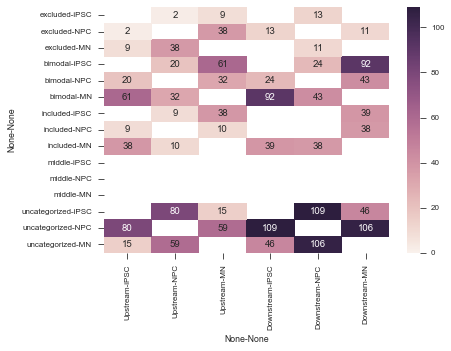

In [58]:
sns.heatmap(enrichment_2d_log10[enrichment_2d_log10 > 0], vmin=0, annot=True, fmt='.0f')

## Plot basewise conservation

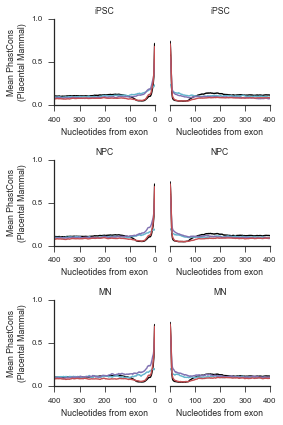

In [23]:
g = sns.FacetGrid(modality_basewise_conservation, hue='modality', hue_order=modality_order,
                 palette=modality_palette, row='phenotype', row_order=study.phenotype_order,
                  col='direction', sharex=False, #gridspec_kws=dict(wspace=0.1), #legend=False,
                  col_order=intron_order, size=2)
g.map(plt.plot, 'genome_direction_nt', 'Conservation')
for ax in g.axes.flat:
    ax.locator_params(nbins=4)
#         ax.locator_params('y', nbins=4)
    if ax.is_first_col():
        ax.set(ylabel='Mean PhastCons\n(Placental Mammal)',
               xticklabels=list(reversed([int(x) for x in ax.get_xticks()])))
    else:
        sns.despine(ax=ax, left=True)
        ax.yaxis.set_ticks_position('none')
g.set_titles('{row_name}')
g.set(xlabel='Nucleotides from exon', ylim=(0, 1))
# g.add_legend();
g.fig.subplots_adjust(wspace=0.01)
g.fig.tight_layout()
g.savefig('{}/intron_basewise_conservation_400nt.pdf'.format(figure_folder))

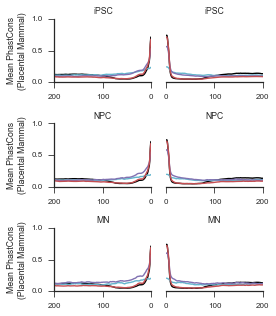

In [24]:
g = sns.FacetGrid(modality_basewise_conservation, hue='modality', hue_order=modality_order,
                 palette=modality_palette, row='phenotype', row_order=study.phenotype_order,
                  col='direction', sharex=False, #gridspec_kws=dict(wspace=0.2), #legend=False,
                  col_order=intron_order, size=1.5, aspect=1.3)
g.map(plt.plot, 'genome_direction_nt', 'Conservation')
for ax in g.axes.flat:
    ax.locator_params(nbins=4)
#         ax.locator_params('y', nbins=4)
    if ax.is_first_col():
        xticklabels = ax.get_xticks()
        ax.set(xlim=(200, 400))
        ax.set(ylabel='Mean PhastCons\n(Placental Mammal)',
               xticklabels=[200, 100, 0], xticks=(200, 300, 400))
    else:
        sns.despine(ax=ax, left=True)
        ax.yaxis.set_ticks_position('none')
        ax.set(xlim=(0, 200), xticklabels=[0, 100, 200], xticks=[0, 100, 200])
g.set_titles('{row_name}')
g.set(xlabel='', ylim=(0, 1))
# g.add_legend();
g.fig.subplots_adjust(wspace=0.01)
g.fig.tight_layout()
g.savefig('{}/intron_basewise_conservation_200nt.pdf'.format(figure_folder))

In [25]:
# import matplotlib as mpl
# dark2 = sns.color_palette('Dark2', n_colors=10)
# sns.palplot(dark2)
# accent = sns.color_palette('Accent', n_colors=10)
# sns.palplot(accent)

# sns.palplot(sns.color_palette('PRGn', n_colors=2))
# direction_to_color = dict(zip(['upstream', 'downstream'], 
#                             map(mpl.colors.rgb2hex, sns.color_palette('PRGn', n_colors=2))))


# # This is the winner!!
# import matplotlib as mpl
# celltype_palette = dark2[0], accent[4], dark2[3], accent[2]
# sns.palplot(celltype_palette)

# celltype_palette = map(mpl.colors.rgb2hex, celltype_palette)

# phenotype_to_color = dict(zip(['iPSC', 'NPC', "MN", "sMN"], celltype_palette))
# phenotype_to_color

In [26]:
cmap = sns.dark_palette((177, 66, 90), as_cmap=True, input='husl')

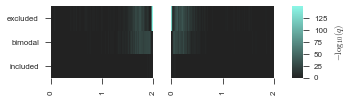

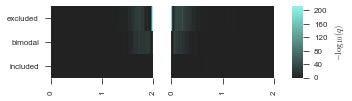

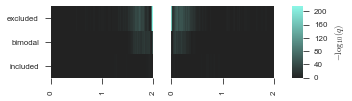

In [27]:
for phenotype, phenotype_df in modality_basewise_statistics.groupby('phenotype'):
    # PLot significance of basewise statistics
    figwidth = 2.5 * 2
    figheight = 0.3 * len(modality_basewise_statistics.groupby('modality').groups)

    fig, axes = plt.subplots(ncols=3, figsize=(figwidth, figheight), gridspec_kw=dict(width_ratios=[1, 1, 0.1]))
    cbar_ax = axes[-1]

    grouped = phenotype_df.groupby('intron')

    for intron, ax in zip(intron_order, axes):
        df = grouped.get_group(intron)
        basewise_statistics_2d = df.pivot(index='modality', columns='genome_direction_nt', values='$-\log_{10}(q)$')
        basewise_statistics_2d = basewise_statistics_2d.loc[MODALITY_ORDER[:3]].dropna()
        sns.heatmap(basewise_statistics_2d, cmap=cmap, ax=ax, vmin=0,
                    cbar_kws=dict(label='$-\log_{10}(q)$'), 
                    cbar_ax=cbar_ax)
        ax.set(ylabel='', xlabel='', xticks=[0, 200, 400])
        if not ax.is_first_col():
            ax.set(yticks=[], ylabel='')
        else:
            plt.setp(ax.get_yticklabels(), rotation=0)
    fig.subplots_adjust(wspace=0.01)
    fig.tight_layout()
    fig.savefig('{}/intron_basewise_conservation_statistics_{}_q_values.pdf'.format(figure_folder, phenotype))

In [28]:
# cmap = sns.light_palette((177, 66, 90), as_cmap=True, input='husl')
cmap = 'Greys'

In [29]:
import matplotlib as mpl

In [30]:
locator = mpl.ticker.MaxNLocator(4)

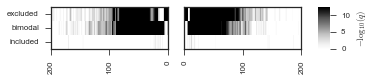

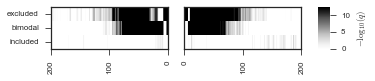

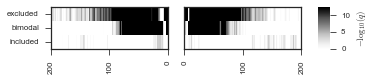

In [31]:
for phenotype, phenotype_df in modality_basewise_statistics.groupby('phenotype'):
    # PLot significance of basewise statistics
    figwidth = 2.5 * 2
    figheight = 0.15 * len(modality_basewise_statistics.groupby('modality').groups)

    fig, axes = plt.subplots(ncols=3, figsize=(figwidth, figheight), 
                             gridspec_kw=dict(width_ratios=[1, 1, 0.1], wspace=0.2))
    cbar_ax = axes[-1]

    grouped = phenotype_df.groupby('intron')

    for intron, ax in zip(intron_order, axes):
        df = grouped.get_group(intron)
        basewise_statistics_2d = df.pivot(index='modality', columns='genome_direction_nt', values='$-\log_{10}(q)$')
        basewise_statistics_2d = basewise_statistics_2d.loc[MODALITY_ORDER[:3]].dropna()
        sns.heatmap(basewise_statistics_2d, cmap=cmap, ax=ax, vmin=0, vmax=10,
                    cbar_kws=dict(label='$-\log_{10}(q)$'), 
                    cbar_ax=cbar_ax)
        ax.set(xticks=[])
        if not ax.is_first_col():
            ax.set(yticks=[], ylabel='', xlim=(0, 200), xlabel='',
                   xticklabels=[0, 100, 200], xticks=(0, 100, 200))
        else:
            plt.setp(ax.get_yticklabels(), rotation=0)
            xticklabels = ax.get_xticks()
            ax.set(xlim=(200, 400), xlabel='', xticklabels=[200, 100, 0], 
                   xticks=(200, 300, 400), ylabel='')
    cbar_ax.locator_params('y', nbins=4)
    cbar_ax.yaxis.set_ticklabels([0, 5, 10])
    fig.subplots_adjust(wspace=0.01)
    sns.despine(bottom=False, right=False, left=False, top=False)
#     fig.tight_layout()
    fig.savefig('{}/intron_basewise_conservation_statistics_{}_q_values_200nt.pdf'.format(figure_folder, phenotype))

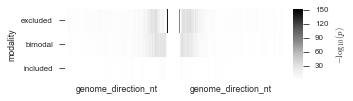

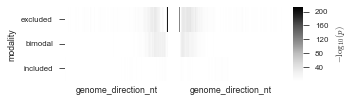

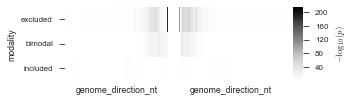

In [32]:
for phenotype, phenotype_df in modality_basewise_statistics.groupby('phenotype'):
    # PLot significance of basewise statistics
    figwidth = 2.5 * 2
    figheight = 0.3 * len(modality_basewise_statistics.groupby('modality').groups)

    fig, axes = plt.subplots(ncols=3, figsize=(figwidth, figheight), gridspec_kw=dict(width_ratios=[1, 1, 0.1]))
    cbar_ax = axes[-1]

    grouped = phenotype_df.groupby('intron')

    for intron, ax in zip(intron_order, axes):
        df = grouped.get_group(intron)
        basewise_statistics_2d = df.pivot(index='modality', columns='genome_direction_nt', values='$-\log_{10}(p)$')
        basewise_statistics_2d = basewise_statistics_2d.loc[MODALITY_ORDER[:3]].dropna()
        sns.heatmap(basewise_statistics_2d, cmap=cmap, ax=ax,
                    cbar_kws=dict(label='$-\log_{10}(p)$'), 
                    cbar_ax=cbar_ax)
        ax.set(xticks=[])
        if not ax.is_first_col():
            ax.set(yticks=[], ylabel='')
        else:
            plt.setp(ax.get_yticklabels(), rotation=0)
    fig.subplots_adjust(wspace=0.01)
    fig.tight_layout()
    fig.savefig('{}/intron_basewise_conservation_statistics_{}_p_values.pdf'.format(figure_folder, phenotype))